In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import numpy as np
from scipy.stats import chi2_contingency
from sklearn.preprocessing import OneHotEncoder

import statsmodels.api as sm
import math
import kagglehub
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Download the dataset
path = kagglehub.dataset_download("alexteboul/heart-disease-health-indicators-dataset")
print("Path to dataset files:", path)
df = pd.read_csv(f"{path}/heart_disease_health_indicators_BRFSS2015.csv")
df.columns
# Bin BMI as per your code
df['BMI_Binned'] = np.where(df['BMI'] <= 30, 1, 2)

# One-hot encode the Diabetes column
one_hot = pd.get_dummies(df['Diabetes'], prefix='Diabetes')
df = pd.concat([df, one_hot], axis=1)

# List of categorical columns (including one-hot encoded Diabetes columns)
categorical_columns = [
    'HeartDiseaseorAttack', 'HighBP', 'HighChol', 'CholCheck', 'Smoker', 'Stroke',
    'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare',
    'NoDocbcCost', 'GenHlth', 'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age',
    'Education', 'Income', 'BMI_Binned'
] + one_hot.columns.tolist()


Path to dataset files: C:\Users\ssjed\.cache\kagglehub\datasets\alexteboul\heart-disease-health-indicators-dataset\versions\3


# Testing Independence of Observations

In [3]:
#Inferred from dataset

# Testing of Collinearity among predictors

In [4]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Select numeric predictors only
X = df.select_dtypes(include=[np.number])

# Add constant for VIF calculation
X = add_constant(X)

# Calculate VIF
vif = pd.DataFrame()
vif['Variable'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif)


                Variable         VIF
0                  const  117.012631
1   HeartDiseaseorAttack    1.175660
2                 HighBP    1.347464
3               HighChol    1.182116
4              CholCheck    1.033613
5                    BMI    2.366373
6                 Smoker    1.091887
7                 Stroke    1.081617
8               Diabetes    1.211187
9           PhysActivity    1.157814
10                Fruits    1.112642
11               Veggies    1.112407
12     HvyAlcoholConsump    1.025498
13         AnyHealthcare    1.113217
14           NoDocbcCost    1.144174
15               GenHlth    1.826621
16              MentHlth    1.239444
17              PhysHlth    1.623607
18              DiffWalk    1.536979
19                   Sex    1.077449
20                   Age    1.358552
21             Education    1.326651
22                Income    1.506061
23            BMI_Binned    2.305818


# Testing Outliers

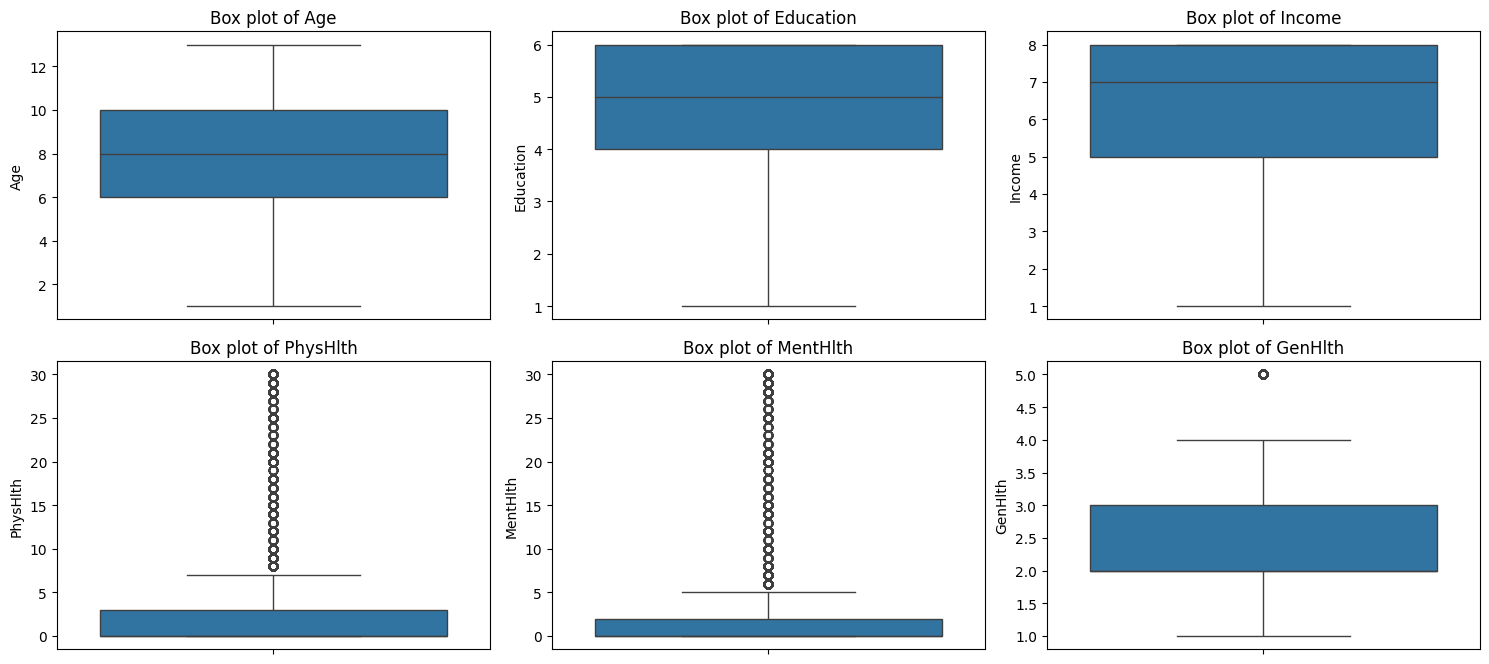

Number of outliers per numerical feature:
Age              0
Education     4217
Income           0
PhysHlth         0
MentHlth     12697
GenHlth          0
dtype: int64


In [5]:
numerical_columns = ['Age', 'Education', 'Income', 'PhysHlth', 'MentHlth', 'GenHlth']

# Box plots for numerical variables
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_columns, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(y=df[col])
    plt.title(f'Box plot of {col}')
plt.tight_layout()
plt.show()

# Alternatively, using Z-scores to detect outliers
from scipy import stats

z_scores = np.abs(stats.zscore(df[numerical_columns]))
threshold = 3
outliers = (z_scores > threshold).sum()
print("Number of outliers per numerical feature:")
print(outliers)

# Linearity of Log Odds and Predictors

In [6]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

continuous_columns = [col for col in df.columns.to_list() if col not in categorical_columns + ['HeartDiseaseorAttack', 'BMI', 'Diabetes']]

# Function to plot predictor vs logit
def plot_predictor_logit(df, predictor, target):
    # Create a logistic regression model with the predictor
    model = sm.Logit(df[target], sm.add_constant(df[predictor]))
    result = model.fit(disp=False)
    
    # Calculate predicted probabilities
    df['pred_prob'] = result.predict(sm.add_constant(df[predictor]))
    
    # Avoid log(0) by replacing 0 and 1
    df['pred_prob'] = df['pred_prob'].replace({0: 1e-5, 1: 1-1e-5})
    
    # Calculate logit
    df['logit'] = np.log(df['pred_prob'] / (1 - df['pred_prob']))
    
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=predictor, y='logit', data=df, alpha=0.5)
    plt.title(f'Logit vs {predictor}')
    plt.xlabel(predictor)
    plt.ylabel('Logit (Log Odds)')
    plt.show()

# Example usage for each continuous predictor
for col in continuous_columns:
    plot_predictor_logit(df, col, 'HeartDiseaseorAttack')


# Took out BMI which was main continuous column

# Testing Independence of Errors

# Logistic Regression Model

In [ ]:
import statsmodels.api as sm
from sklearn.model_selection import train_test_split

# Encode categorical variables and prepare data
X = pd.get_dummies(df.drop(columns=['HeartDiseaseorAttack']), drop_first=True)
y = df['HeartDiseaseorAttack']

# Ensure all data is numeric and handle missing values
X = X.apply(pd.to_numeric, errors='coerce').fillna(0)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Add a constant term for intercept
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

# Convert to numpy arrays
X_train = np.asarray(X_train).astype(np.float64)
y_train = np.asarray(y_train).astype(np.float64)

# Fit logistic regression model
full_model = sm.Logit(y_train, X_train).fit()
print(full_model.summary())

Optimization terminated successfully.
         Current function value: 0.238681
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:               177576
Model:                          Logit   Df Residuals:                   177551
Method:                           MLE   Df Model:                           24
Date:                Tue, 19 Nov 2024   Pseudo R-squ.:                  0.2375
Time:                        19:44:25   Log-Likelihood:                -42384.
converged:                       True   LL-Null:                       -55585.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.7484   1.68e+05  -2.82e-05      1.000    -3.3e+05     3.3e+05
x1             0.5317      0.

# Analyze Interactions

# Backward Selection

# Forward Selection

# Evaluate Models
